# Introduction 

## Project Background
The podcast industry has expanded dramatically over the previous decade. By 2024, there will be over 4.5 million active podcasts and 70 million episodes worldwide. With this expansion, it has become critical for platforms and content creators to understand consumer preferences and behavior. Podcast ratings have evolved as an important tool for evaluating user satisfaction and content quality.
Ratings not only assess listener pleasure, but they are also used by platform algorithms to propose content and affect potential listeners' podcast choices. Even minor changes in a podcast's average rating can have a substantial influence on discoverability, listenership, and profitability.


## The purpose of the project
This initiative seeks to give a complete study of podcast data on the platform. It seeks to provide in-depth information about the podcast ecosystem.
This review focuses on the advantages of podcasting systems, their users, and the podcast ecosystem. The insights can help to optimize content strategies, improve user experience, and create more effective rating systems.
Questionsity Analysis

* Here are the project's main milestones:

1) Is it possible to conduct significant analysis on podcast category performance?
2) What are the current podcast design trends (2010–2022), and what tactics should be used?
3) Rating Distribution Features: What are the most popular podcast categories, and what distinguishes them from others?
4) The following categories are linked to statistics. Can statistical tests (t-tests, ANOVA, and confidence intervals) be used to examine how categorizes affect the distribution of variables?
5) Correlation Analysis: What is the link between the number of reviews and the average rating, and does it vary by podcast genre?
6) The Five-Star Rating Phenomenon: What percentage of users give 5 stars in different categories, and are there any notable disparities in this behavior that could suggest varying degrees of listener engagement?

## Methodology and Veracity
With over 2 million subscribers and 110,000 active podcasts, this website is a valuable resource. The forecasts for 2005-2023 are based on 2010-2022 data.
Our analysis is extensive, encompassing exploratory data analysis, statistical hypothesis testing, time series analysis, and correlation analysis. Graphs, charts, tables, and statistics can be used to analyze and report large amounts of data.

## Project Overview
Here are some important aspects to consider:

- You can quickly find relevant podcast genres.
- Discover the advantages and disadvantages of utilizing podcasts.
- Here are some suggestions for optimizing podcast content strategy.
- Decoding systems and algorithms can help to increase performance.
- Create effective, category-specific strategies for podcast creators and platform management.

* This analysis emphasizes the relevance of podcast platforms and content creators in gaining success and reaping rewards through smart techniques.

### Importing Required Libraries and Data Loading


In [1]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import datetime
from scipy.stats import chi2_contingency


%matplotlib inline
matplotlib.use('TkAgg')

In [2]:
database_path = "/Users/mustafaakgul/Desktop/database.sqlite"
conn = sqlite3.connect(database_path)

# Exploratory Data Analysis

In this section, we'll conduct a thorough exploration of the podcast ratings database to uncover key patterns, distributions, and relationships before proceeding to more formal statistical analyses. Exploratory Data Analysis (EDA) allows us to develop a deeper understanding of the dataset, identify potential issues, and formulate hypotheses that will guide our subsequent investigations.
Our EDA will focus on several key aspects:

* Data Quality Assessment: We'll examine the completeness of the dataset, identify any missing values, outliers, or anomalies that might affect our analyses.
* Statistical Summaries: We'll calculate descriptive statistics for ratings across different categories to understand central tendencies, variability, and distributions.
* Categorical Breakdowns: We'll explore how podcast categories are distributed in our dataset and identify the most popular and niche categories.
* Temporal Patterns: We'll investigate how ratings have evolved over time and whether there are any seasonal or annual trends worth noting.
* Rating Distributions: We'll visualize and analyze the distribution of ratings to understand user behavior and identify any skewness or unusual patterns.
* Relationship Explorations: We'll examine relationships between variables such as the correlation between number of reviews and average ratings.

Through visualizations and summary statistics, this exploratory phase will help us develop a comprehensive understanding of the podcast ecosystem as reflected in our dataset, and lay the groundwork for the more targeted analyses that follow.

# Data Quality and Preprocessing


In [3]:
query = "SELECT name FROM sqlite_master WHERE type='table'"
df = pd.read_sql(query, conn)
print(df.head().T)

         0         1           2        3
name  runs  podcasts  categories  reviews


There are four tables in the database.

In [4]:
df = pd.read_sql("select * from reviews ", conn)
missing_values = df.isnull().sum()
missing_perc = 100 * df.isnull().sum() / len(df)
print("Missing Percentage:", missing_perc)

Missing Percentage: podcast_id    0.0
title         0.0
content       0.0
rating        0.0
author_id     0.0
created_at    0.0
dtype: float64


In [5]:
df = pd.read_sql("select * from categories ", conn)
missing_values = df.isnull().sum()
missing_perc = 100 * df.isnull().sum() / len(df)
print("Missing Percentage:", missing_perc)

Missing Percentage: podcast_id    0.0
category      0.0
dtype: float64


In [6]:
df = pd.read_sql("select * from podcasts ", conn)
missing_values = df.isnull().sum()
missing_perc = 100 * df.isnull().sum() / len(df)
print("Missing Percentage:", missing_perc)

Missing Percentage: podcast_id    0.0
itunes_id     0.0
slug          0.0
itunes_url    0.0
title         0.0
dtype: float64


There are no missing values in the tables examined. All podcast_id, rating, created_at and other critical fields are complete.

In [7]:
df = pd.read_sql("""SELECT 
    COUNT(*) AS total_rows,
    COUNT(rating) AS rating_nonnull,
    AVG(rating) AS avg_rating,
    MIN(rating) AS min_rating,
    MAX(rating) AS max_rating
FROM reviews;""", conn)

print(df.to_string(index=False))

 total_rows  rating_nonnull  avg_rating  min_rating  max_rating
    2067529         2067529    4.627081           1           5


There are approximately 2 million comments and non of them is Null. Minimum rating is 1 and maximum rating is 5, the average of all ratings is 4.62

In [8]:
query = ("SELECT COUNT(distinct podcast_id) as Unique_Podcasts_Count "
         "FROM podcasts;")
df = pd.read_sql(query, conn)
print( df.to_string(index=False))

 Unique_Podcasts_Count
                110024


In [9]:
df_reviews = pd.read_sql("SELECT * FROM reviews", conn)
mapping = str.maketrans("۰۱۲۳۴۵۶۷۸۹", "0123456789") #Changing to Latin for occurred_at column
df_reviews["created_at"] = df_reviews["created_at"].apply(lambda x: x.translate(mapping))

query = """
SELECT 
    strftime('%Y-%m-%d', min(created_at)) as Earliest_creation, 
    strftime('%Y-%m-%d', max(created_at)) as Latest_creation
    FROM reviews
    where created_at LIKE '%20%'
"""
df_summary = pd.read_sql(query, conn)
print(df_summary)

  Earliest_creation Latest_creation
0        2005-12-10      2023-02-16


In [10]:
df = pd.read_sql("""SELECT 
    c.category,
    COUNT(r.rating) AS count_reviews,
    AVG(r.rating) AS mean_rating,
    MIN(r.rating) AS min_rating,
    MAX(r.rating) AS max_rating,
    sqrt(AVG(r.rating * r.rating) - AVG(r.rating) * AVG(r.rating)) AS std_rating
FROM reviews r
JOIN categories c ON r.podcast_id = c.podcast_id
GROUP BY c.category""",conn)
df

,category,count_reviews,mean_rating,min_rating,max_rating,std_rating
0,arts,136508,4.727782,1,5,0.881267
1,arts-books,30613,4.681933,1,5,0.937675
2,arts-design,9431,4.811367,1,5,0.719145
3,arts-fashion-beauty,14945,4.649716,1,5,1.014359
4,arts-food,16556,4.781107,1,5,0.798976
...,...,...,...,...,...,...
105,tv-film-after-shows,27184,4.391995,1,5,1.309922
106,tv-film-film-history,6173,4.671959,1,5,0.950987
107,tv-film-film-interviews,6011,4.773748,1,5,0.837514
108,tv-film-film-reviews,22556,4.752084,1,5,0.856933


In [11]:
print(f"Total number of categories: {df.shape[0]}")


Total number of categories: 110


In [12]:
top_categories = df.sort_values(by='count_reviews', ascending=False).head(10)
print("Top 10 categories by number of reviews:")
print(top_categories[['category', 'count_reviews', 'mean_rating']])

Top 10 categories by number of reviews:
                  category  count_reviews  mean_rating
79         society-culture         441874     4.546984
16                  comedy         350848     4.623424
20               education         221831     4.813994
8                 business         210081     4.839410
59                    news         180552     4.301110
86                  sports         175709     4.612251
30          health-fitness         174310     4.788056
104                tv-film         169915     4.518006
103             true-crime         162550     4.163857
68   religion-spirituality         146633     4.832466


In [13]:
top_rated = df.sort_values(by='mean_rating', ascending=False).head(10)
print("Top 10 categories by average rating:")
print(top_rated[['category', 'mean_rating', 'count_reviews']])


Top 10 categories by average rating:
                      category  mean_rating  count_reviews
94                sports-rugby     4.988024            167
13          business-marketing     4.937095          28869
10   business-entrepreneurship     4.908377          80242
14         business-non-profit     4.901167           2570
97             sports-swimming     4.892308            130
95              sports-running     4.891993           6157
9             business-careers     4.890061          53921
71           science-chemistry     4.882716            162
35    health-fitness-nutrition     4.880982          22148
24  education-self-improvement     4.876771         103961


### Data Set Properties
* The podcast rating database used in this study has the following characteristics:
- Data Coverage: A total of 2,067,529 ratings collected between 2005 and 2023
- Podcast Count: 110,024 unique podcasts
- Number of Categories: 110 different podcast categories
- Rating Scale: 1-5 stars (whole number values)
- Data Period: Assessments collected between 2005-12-10 and 2023-02-16
- Database Structure: 4 tables (podcasts, reviews, categories, runs) in SQLite database

### Data Quality Assessment
* When the database was analyzed, the following quality characteristics were identified:
- Missing Values: There are no missing values in the tables examined. All podcast_id, rating, created_at and other critical fields are complete.
- Rating Distribution: The average value for all ratings is 4.627. This indicates a positive skewness in the data.
- Timestamps: In some created_at values, digits from different character sets were detected and standardized.

## Outliers

In [14]:
query = """
SELECT 
    c.category,
    COUNT(r.rating) AS review_count,
    AVG(r.rating) AS mean_rating,
    SQRT(AVG(r.rating * r.rating) - AVG(r.rating) * AVG(r.rating)) AS std_rating
FROM 
    reviews r
JOIN 
    categories c ON r.podcast_id = c.podcast_id
GROUP BY 
    c.category
"""
df = pd.read_sql(query, conn)

def detect_outliers_iqr(df, columns, factor=1.5):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        df[f'{column}_outlier'] = (df[column] < lower_bound) | (df[column] > upper_bound)
    return df
columns_to_check = [ 'review_count', 'mean_rating', 'std_rating']
outliers_iqr = detect_outliers_iqr(df.copy(), columns_to_check)
print(f"\nOutliers detected by the IQR method ({len(outliers_iqr)} categories):")
print(outliers_iqr[['category'] + columns_to_check])

    



Outliers detected by the IQR method (110 categories):
                    category  review_count  mean_rating  std_rating
0                       arts        136508     4.727782    0.881267
1                 arts-books         30613     4.681933    0.937675
2                arts-design          9431     4.811367    0.719145
3        arts-fashion-beauty         14945     4.649716    1.014359
4                  arts-food         16556     4.781107    0.798976
..                       ...           ...          ...         ...
105      tv-film-after-shows         27184     4.391995    1.309922
106     tv-film-film-history          6173     4.671959    0.950987
107  tv-film-film-interviews          6011     4.773748    0.837514
108     tv-film-film-reviews         22556     4.752084    0.856933
109       tv-film-tv-reviews         20202     4.552322    1.131822

[110 rows x 4 columns]


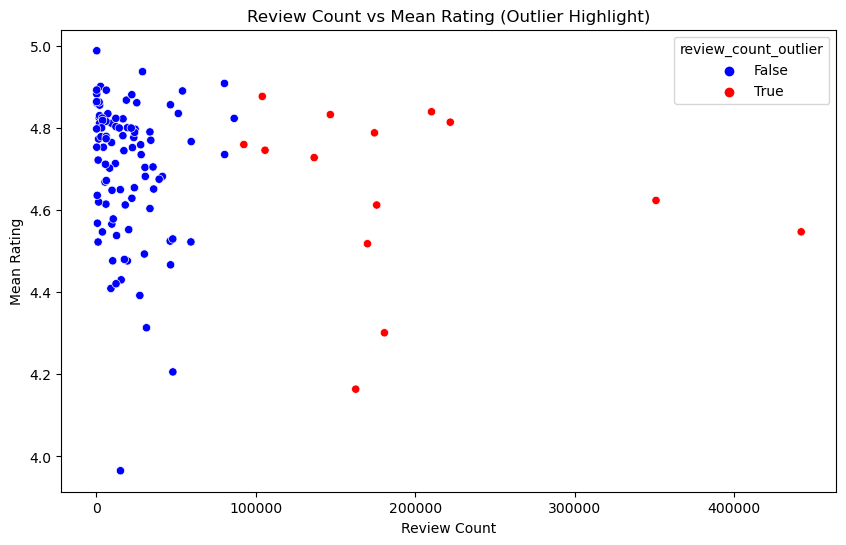

In [15]:
%matplotlib inline

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='review_count',
    y='mean_rating',
    data=outliers_iqr,
    hue='review_count_outlier', 
    palette={False: 'blue', True: 'red'},
    legend='full'
)
plt.title("Review Count vs Mean Rating (Outlier Highlight)")
plt.xlabel("Review Count")
plt.ylabel("Mean Rating")
plt.show()

* The vast majority of podcasts have a rating between 4.6 and 4.9 and the average number of comments is between 0 and 100,000. 
* Some podcasts with particularly good ratings (around 4.8) have received over 100,000 comments due to their popularity and are seen as outliers. 

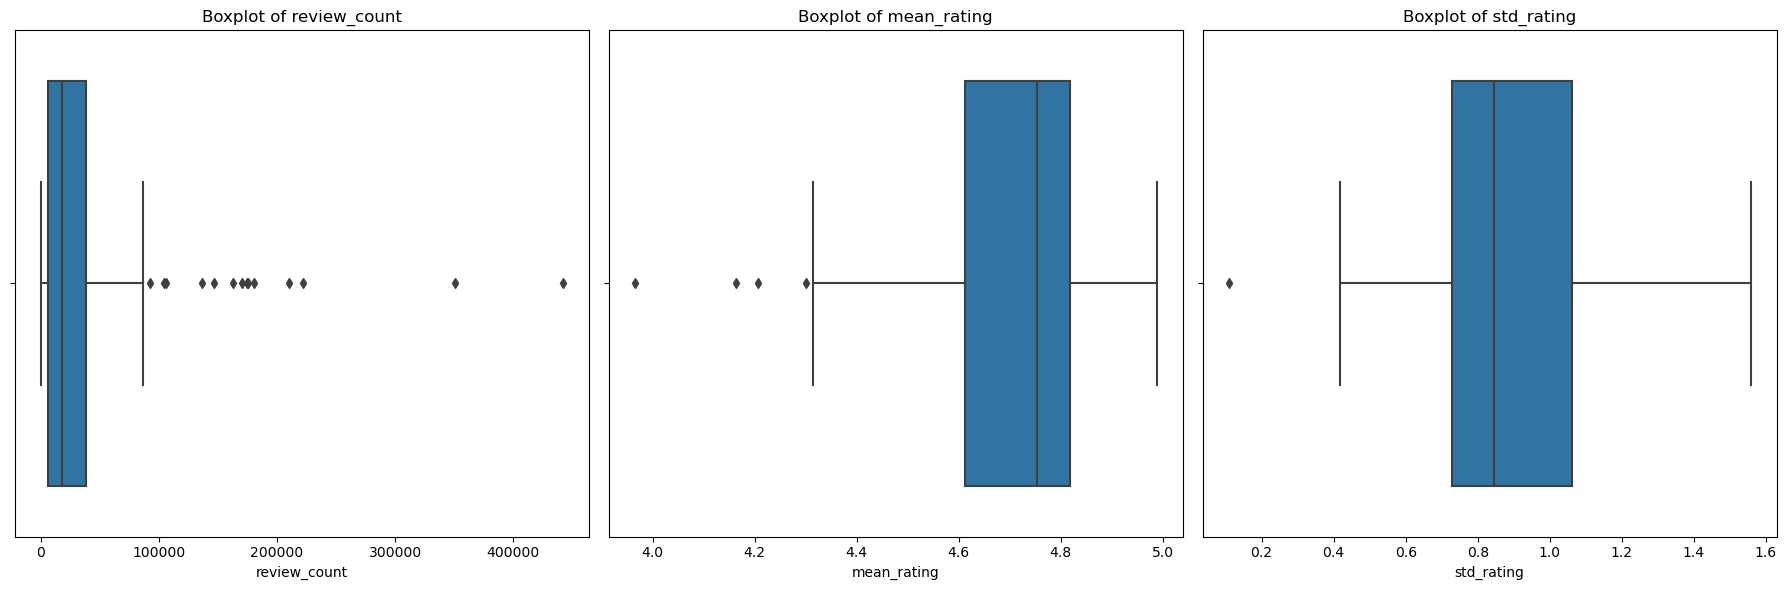

In [16]:
columns_to_visualize = ['review_count', 'mean_rating', 'std_rating']
fig, axs = plt.subplots(1, len(columns_to_visualize), figsize=(18, 6))

for ax, col in zip(axs, columns_to_visualize):
    # Boxplot 
    sns.boxplot(x=outliers_iqr[col], ax=ax)
    ax.set_title(f"Boxplot of {col}")
    ax.set_xlabel(col)

plt.tight_layout()
plt.show()

* Review Count Boxplot:  There is “long tail” behavior in the dataset, with most items receiving few reviews, while a few are outliers with a very high number of reviews.
* Mean Rating Boxplot: Mean ratings are quite high (in the 4.5-5.0 range) and narrowly clustered. This indicates that the podcasts rated are generally positive.
* Std. Rating Boxplot: Ratings are moderately varied, with a standard deviation mostly around 1.0. However, some items exceed 1.5, indicating a significant difference of opinion.

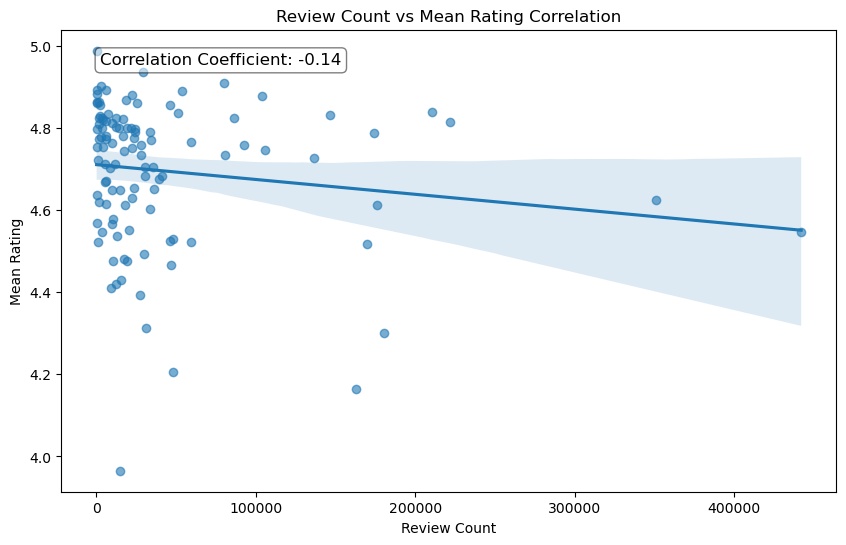

In [17]:
corr_coef = outliers_iqr['review_count'].corr(outliers_iqr['mean_rating'])

plt.figure(figsize=(10, 6))
sns.regplot(x='review_count', y='mean_rating', data=outliers_iqr, scatter_kws={'alpha':0.6})

plt.text(
    0.05, 0.95, f'Correlation Coefficient: {corr_coef:.2f}',
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox={'boxstyle':'round', 'facecolor':'white', 'alpha':0.5}
)

plt.title("Review Count vs Mean Rating Correlation")
plt.xlabel("Review Count")
plt.ylabel("Mean Rating")
plt.show()


* As the number of reviews increases, we can observe that the average score may slightly decrease towards 4.5 and below.
* The average number of reviews is below 5000.
* The weak correlation (-0.14) indicates that items with many reviews tend to have a slightly lower rating, but the relationship is not strong.
* The data seems to be mostly gathered in the 4.4-4.8 average score range and 0-20,000 review_count band.

# Exploratory Data Analysis (EDA)

### Top 15 Podcast Categories by Number of Reviews

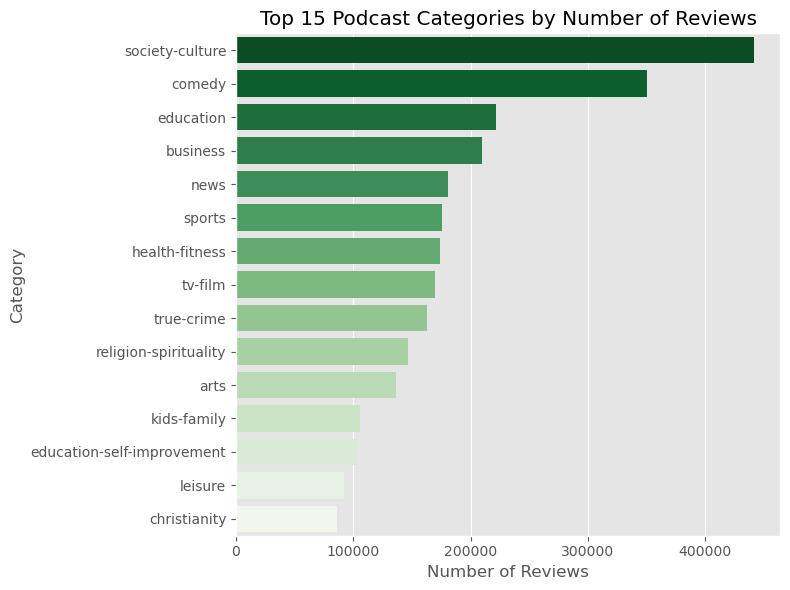

In [18]:
query = """SELECT 
    c.category,
    COUNT(r.rating) AS count_reviews,
    AVG(r.rating) AS mean_rating,
    MIN(r.rating) AS min_rating,
    MAX(r.rating) AS max_rating,
    sqrt(AVG(r.rating * r.rating) - AVG(r.rating) * AVG(r.rating)) AS std_rating
FROM reviews r
JOIN categories c ON r.podcast_id = c.podcast_id
GROUP BY c.category"""

df = pd.read_sql(query, conn) 

plt.style.use('ggplot')

palette = sns.color_palette("Greens", 15)[::-1]

# Visualize the top 15 categories by number of reviews
plt.figure(figsize=(8, 6))
sns.barplot(
    x='count_reviews',
    y='category',
    data=df.sort_values('count_reviews', ascending=False).head(15),
    palette=palette  # Dark green to light green gradient
)
plt.title('Top 15 Podcast Categories by Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Category')
plt.tight_layout()
plt.savefig('top_categories_by_reviews.png')
plt.show()


By far the most comments were in the Society-Culture category, followed by Comedy. 

### Top 15 Podcast Categories by Average Rating (Min. 1000 Reviews)

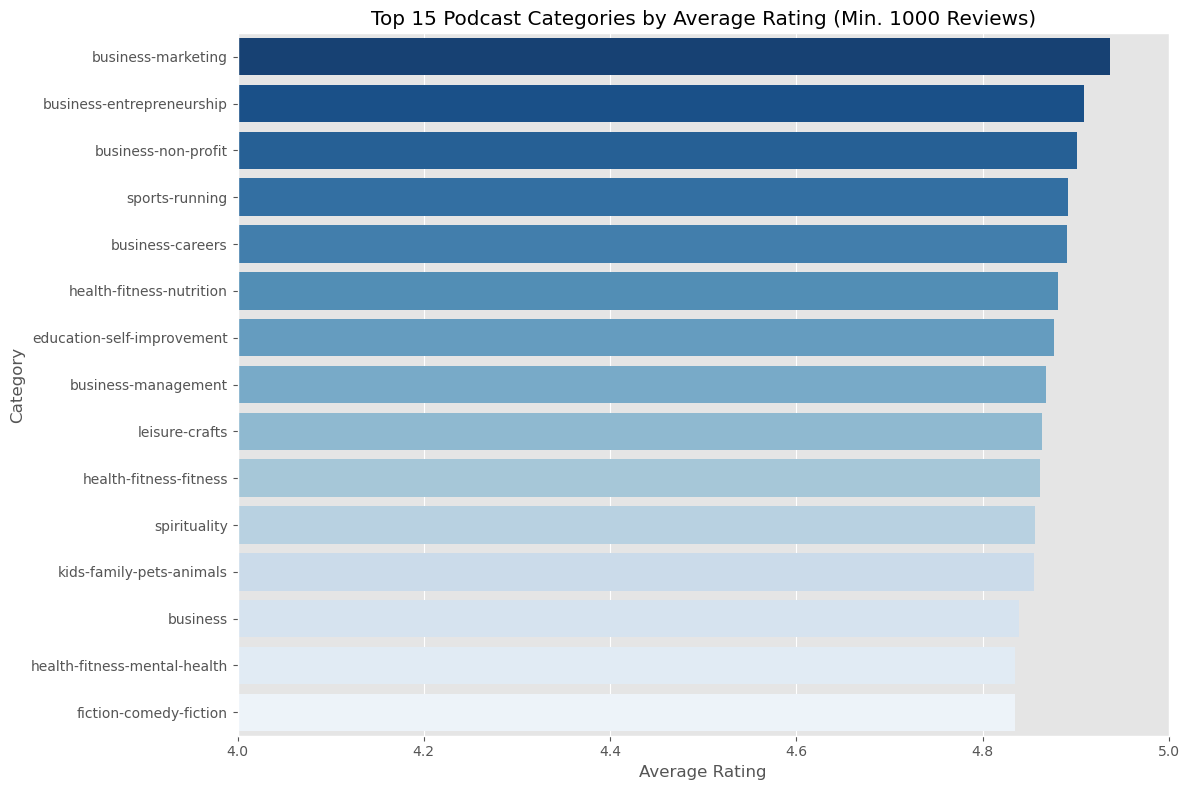

In [19]:
%matplotlib inline
query = """SELECT 
    c.category,
    COUNT(r.rating) AS count_reviews,
    AVG(r.rating) AS mean_rating,
    MIN(r.rating) AS min_rating,
    MAX(r.rating) AS max_rating,
    sqrt(AVG(r.rating * r.rating) - AVG(r.rating) * AVG(r.rating)) AS std_rating
FROM reviews r
JOIN categories c ON r.podcast_id = c.podcast_id
GROUP BY c.category"""

df = pd.read_sql(query, conn)

plt.style.use('ggplot')

# Select categories with more than 1000 reviews and take the top 15 sorted in descending order by mean_rating
top15_by_rating = df[df['count_reviews'] > 1000].sort_values('mean_rating', ascending=False).head(15)

# so that the highest average gets dark blue, while the lowest average gets light blue.
palette = sns.color_palette("Blues", len(top15_by_rating))[::-1]

plt.figure(figsize=(12, 8))
sns.barplot(
    x='mean_rating',
    y='category',
    data=top15_by_rating,
    palette=palette  # Gradient from dark blue to light blue
)
plt.title('Top 15 Podcast Categories by Average Rating (Min. 1000 Reviews)')
plt.xlabel('Average Rating')
plt.ylabel('Category')
plt.xlim(4.0, 5.0)  # Set x-axis limits to better see the differences
plt.tight_layout()
plt.savefig('top_categories_by_rating.png')
plt.show()


When it is analyzed which categories receive the highest ratings in high-comment podcasts, it is seen that the category with the highest rating scores is the “Business” category in three of the top five categories. The average rating of the best of the podcasts with the most reviews is a successful 4.8+.

### Podcast Categories: Number of Reviews vs Average Rating

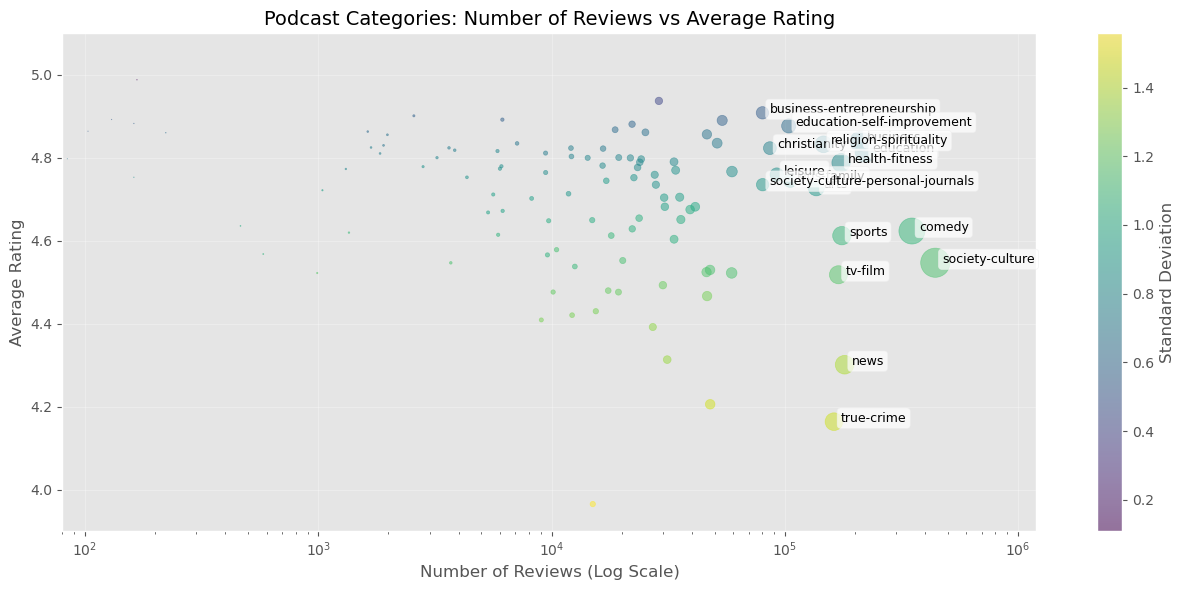

In [20]:
plt.figure(figsize=(13, 6))  # Make the graph larger

# Reduce the size of dots and make them more transparent
plt.scatter(df['count_reviews'], df['mean_rating'], 
            alpha=0.5, s=df['count_reviews']/1000, c=df['std_rating'], cmap='viridis')

plt.colorbar(label='Standard Deviation')
plt.xscale('log')
plt.xlim(80, 1200000)  # Adjust X-axis limits
plt.ylim(3.9, 5.1)     # Adjust Y-axis limits

plt.xlabel('Number of Reviews (Log Scale)', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.title('Podcast Categories: Number of Reviews vs Average Rating', fontsize=14)

# Label only categories above a certain threshold
# Display labels in small boxes for better organization
for i, row in df[df['count_reviews'] > 75000].iterrows():
    plt.annotate(row['category'], 
                 xy=(row['count_reviews'], row['mean_rating']),
                 xytext=(5, 0),  # Shift text slightly away from the dot
                 textcoords='offset points',
                 fontsize=9,
                 bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7))

plt.grid(True, alpha=0.3)  # Add a transparent grid
plt.tight_layout()
plt.savefig('reviews_vs_rating_improved.png', dpi=300)
plt.show()

* The mean score is shown on a vertical scale and the number of comments is shown on a horizontal logarithmic scale. The color of the bubbles indicates the standard deviation. Darker colors indicate a wider distribution and lighter colors indicate regions where the data are more consistent. Names of large bubbles are shown. 
* There is no clear correlation between the average score and the number of comments

### Top 10 Main Categories by Year

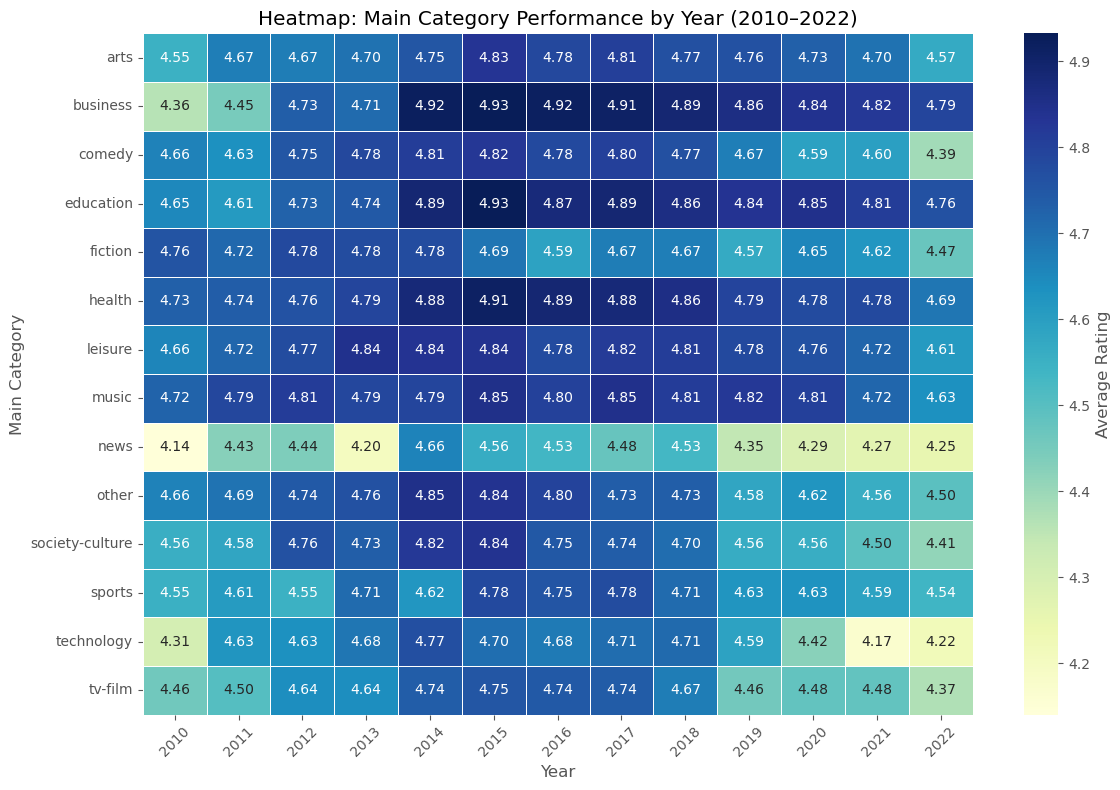

In [21]:
# Make sure plots render inside VS Code Notebook
%matplotlib inline

# 1) Pull annual average ratings for each main category
query = """
SELECT
    CASE 
        WHEN c.category LIKE 'sports%' THEN 'sports'
        WHEN c.category LIKE 'arts%' THEN 'arts'
        WHEN c.category LIKE 'news%' THEN 'news'
        WHEN c.category LIKE 'comedy%' THEN 'comedy'
        WHEN c.category LIKE 'business%' THEN 'business'
        WHEN c.category LIKE 'education%' THEN 'education'
        WHEN c.category LIKE 'society-culture%' THEN 'society-culture'
        WHEN c.category LIKE 'health%' THEN 'health'
        WHEN c.category LIKE 'tv-film%' THEN 'tv-film'
        WHEN c.category LIKE 'music%' THEN 'music'
        WHEN c.category LIKE 'leisure%' THEN 'leisure'
        WHEN c.category LIKE 'technology%' THEN 'technology'
        WHEN c.category LIKE 'fiction%' THEN 'fiction'
        ELSE 'other'
    END AS main_category,
    strftime('%Y', r.created_at) AS year,
    AVG(r.rating) AS avg_rating
FROM reviews r
JOIN categories c 
  ON r.podcast_id = c.podcast_id
WHERE r.rating IS NOT NULL
  AND strftime('%Y', r.created_at) BETWEEN '2010' AND '2022'
GROUP BY main_category, year
ORDER BY main_category, year;
"""
df_yearly = pd.read_sql_query(query, conn)

# 2) Pivot to wide format
heatmap_df = df_yearly.pivot(index='main_category', columns='year', values='avg_rating')


# 3) Draw the heatmap
plt.figure(figsize=(12,8))
sns.heatmap(
    heatmap_df,
    annot=True,       # show cell values
    fmt='.2f',        # two decimals
    linewidths=0.5,
    cmap='YlGnBu',    # yellow→green→blue
    cbar_kws={'label': 'Average Rating'}
)
plt.title('Heatmap: Main Category Performance by Year (2010–2022)')
plt.xlabel('Year')
plt.ylabel('Main Category')
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


- 2015 was a “golden year” with the highest ratings for almost all categories
- Downward trend starts in many categories after 2019
- Significant decline in all categories in 2022

In the podcast ecosystem, 2015 may represent a peak of quality. 
* Information-driven categories such as Business, Education and Health tend to receive higher and more stable ratings
* News content receives the lowest ratings across all time periods

# STATISTICAL HYPOTHESES & CONFIDENCE INTERVALS

## What is confidence intervals of main categories's mean ratings?

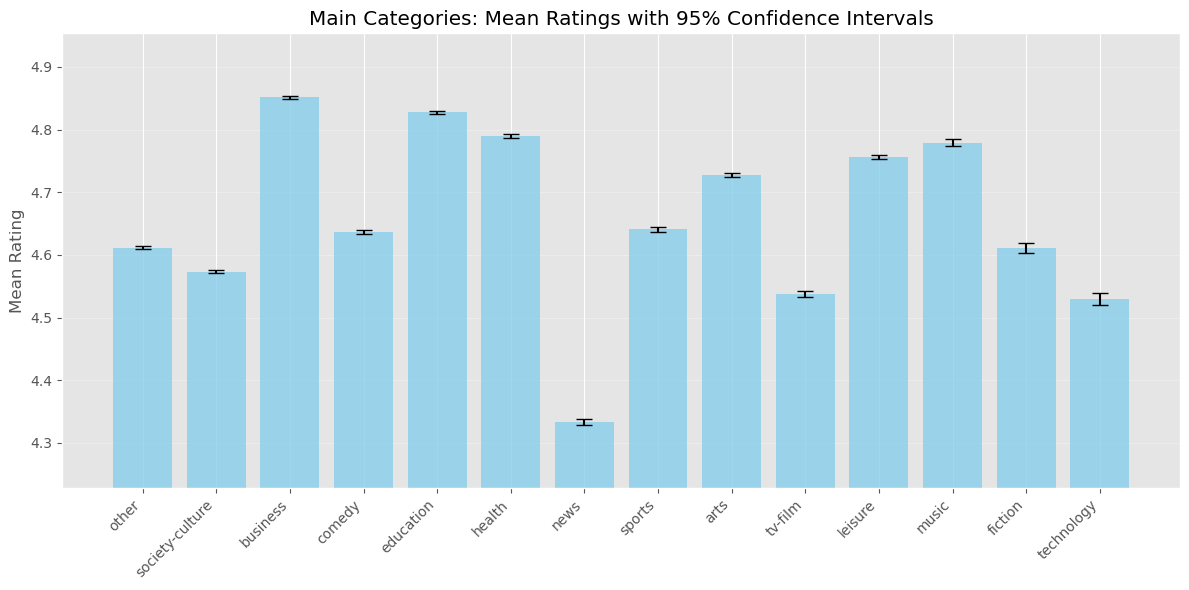

In [22]:
%matplotlib inline


query = """
SELECT
  CASE 
    WHEN c.category LIKE 'sports%'          THEN 'sports'
    WHEN c.category LIKE 'arts%'            THEN 'arts'
    WHEN c.category LIKE 'news%'            THEN 'news'
    WHEN c.category LIKE 'comedy%'          THEN 'comedy'
    WHEN c.category LIKE 'business%'        THEN 'business'
    WHEN c.category LIKE 'education%'       THEN 'education'
    WHEN c.category LIKE 'society-culture%' THEN 'society-culture'
    WHEN c.category LIKE 'health%'          THEN 'health'
    WHEN c.category LIKE 'tv-film%'         THEN 'tv-film'
    WHEN c.category LIKE 'music%'           THEN 'music'
    WHEN c.category LIKE 'leisure%'         THEN 'leisure'
    WHEN c.category LIKE 'technology%'      THEN 'technology'
    WHEN c.category LIKE 'fiction%'         THEN 'fiction'
    ELSE 'other'
  END AS main_category,
  COUNT(r.rating)        AS n,
  AVG(r.rating)          AS mean_rating,
  SQRT(
    AVG(r.rating*r.rating)
    - AVG(r.rating)*AVG(r.rating)
  ) AS std_rating
FROM reviews r
JOIN categories c ON r.podcast_id = c.podcast_id
WHERE r.rating IS NOT NULL
GROUP BY main_category
ORDER BY n DESC;
"""
df = pd.read_sql_query(query, conn)

# 2) Calculate 95% CIs
alpha = 0.05
df['se']     = df['std_rating'] / np.sqrt(df['n'])
df['t_crit'] = stats.t.ppf(1 - alpha/2, df=df['n']-1)
df['me']     = df['t_crit'] * df['se']
df['ci_lower'] = df['mean_rating'] - df['me']
df['ci_upper'] = df['mean_rating'] + df['me']

# 3) Plot: mean + error bars
plt.figure(figsize=(12,6))
x = np.arange(len(df))
means = df['mean_rating']
errors = [means - df['ci_lower'], df['ci_upper'] - means]

plt.bar(x, means, yerr=errors, capsize=6, color='skyblue', alpha=0.8)
plt.xticks(x, df['main_category'], rotation=45, ha='right')
plt.ylabel('Mean Rating')
plt.title('Main Categories: Mean Ratings with 95% Confidence Intervals')
plt.ylim(df['ci_lower'].min() - 0.1, df['ci_upper'].max() + 0.1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


* Confidence intervals in all categories are quite narrow, indicating the size of the dataset and the precision of the estimates
* Information and learning-oriented content (Business, Education, Health) provides the highest user satisfaction
* News content consistently receives lower ratings, suggesting the need for new approaches in this category

## What is the 95% confidence interval for the mean scores of the Arts category?

In [23]:
sql_query = """
SELECT r.rating
FROM reviews r
JOIN categories c ON r.podcast_id = c.podcast_id
WHERE r.rating IS NOT NULL
AND LOWER(c.category) = 'arts';
"""

arts_df = pd.read_sql_query(sql_query, conn)

# Calculate necessary stats
n = len(arts_df)
x_bar = arts_df['rating'].mean()
s = arts_df['rating'].std(ddof=1)

# 95% Confidence Interval using T-distribution
confidence = 0.95
t_critical = stats.t.ppf((1 + confidence) / 2, df=n - 1)
margin_error = t_critical * (s / np.sqrt(n))

lower_bound = x_bar - margin_error
upper_bound = x_bar + margin_error

{
    "Sample Size (n)": n,
    "Sample Mean Rating": round(x_bar, 4),
    "Sample Std Dev": round(s, 4),
    "95% Confidence Interval": [round(lower_bound, 4), round(upper_bound, 4)]
}


{'Sample Size (n)': 136508,
 'Sample Mean Rating': 4.7278,
 'Sample Std Dev': 0.8813,
 '95% Confidence Interval': [4.7231, 4.7325]}

With 95 percent certainty, the average rating of the arts category is between 4.723 and 4.732.

* Podcasts in the Arts category show consistently high ratings from listeners. 


### Is there a significant difference between the mean scores of the subgroups in the Art category?

* H0 (null hypothesis): There is a significant difference between mean scores of the subgroups in the Art category 
* H1 (alternative hypothesis): There is any significant difference between subgroups.

Since we are comparing more than two groups, we use ANOVA to test the hypothesis;


In [24]:
sql_query = """
SELECT 
    c.category AS subgroup,
    r.rating
FROM reviews r
JOIN categories c ON r.podcast_id = c.podcast_id
WHERE r.rating IS NOT NULL
  AND c.category LIKE 'arts-%';
"""

df = pd.read_sql_query(sql_query, conn)

grouped = df.groupby('subgroup')
results = []
z_value = 1.96  

# Calculate summary statistics and 95% confidence interval for each subgroup
for subgroup, group in grouped:
    n = len(group)
    mean_rating = group['rating'].mean()
    std_rating = group['rating'].std(ddof=1)
    se = std_rating / np.sqrt(n)
    margin_error = z_value * se
    lower_bound = mean_rating - margin_error
    upper_bound = mean_rating + margin_error

    results.append({
        'subgroup': subgroup,
        'n': n,
        'mean': mean_rating,
        'std': std_rating,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    })

results_df = pd.DataFrame(results)
print("Summary Statistics and Confidence Intervals for each subgroup:")
print(results_df)

# Collect ratings for each subgroup into separate arrays for ANOVA
groups = [group['rating'].values for _, group in grouped]

# Perform one-way ANOVA test
anova_result = stats.f_oneway(*groups)
print("ANOVA Test Results:")
print("F-statistic: {:.4f}, p-value: {:.4f}".format(anova_result.statistic, anova_result.pvalue))

# Significance Level
alpha = 0.05
if anova_result.pvalue < alpha:
    print("Conclusion: There is a significant difference between the mean scores of the subgroups in the Art category (reject H0).")
else:
    print("Conclusion: There is no significant difference between the mean scores of the subgroups in the Art category (fail to reject H0).")



Summary Statistics and Confidence Intervals for each subgroup:
               subgroup      n      mean       std  lower_bound  upper_bound
0            arts-books  30613  4.681933  0.937690     4.671428     4.692437
1           arts-design   9431  4.811367  0.719183     4.796852     4.825882
2   arts-fashion-beauty  14945  4.649716  1.014393     4.633452     4.665979
3             arts-food  16556  4.781107  0.799000     4.768936     4.793278
4  arts-performing-arts  30404  4.703888  0.911054     4.693647     4.714128
5      arts-visual-arts  16638  4.822154  0.698652     4.811538     4.832770
ANOVA Test Results:
F-statistic: 112.9670, p-value: 0.0000
Conclusion: There is a significant difference between the mean scores of the subgroups in the Art category (reject H0).


* There is a statistically significant difference between subgroups (p < 0.05). This indicates that some categories consistently score higher/lower than others.
* Visual arts and design have the highest average ratings, indicating a higher appreciation of podcast content in these areas.
* The fashion and beauty category has both the lowest average score and the highest standard deviation, indicating that reviews are more diverse and controversial.

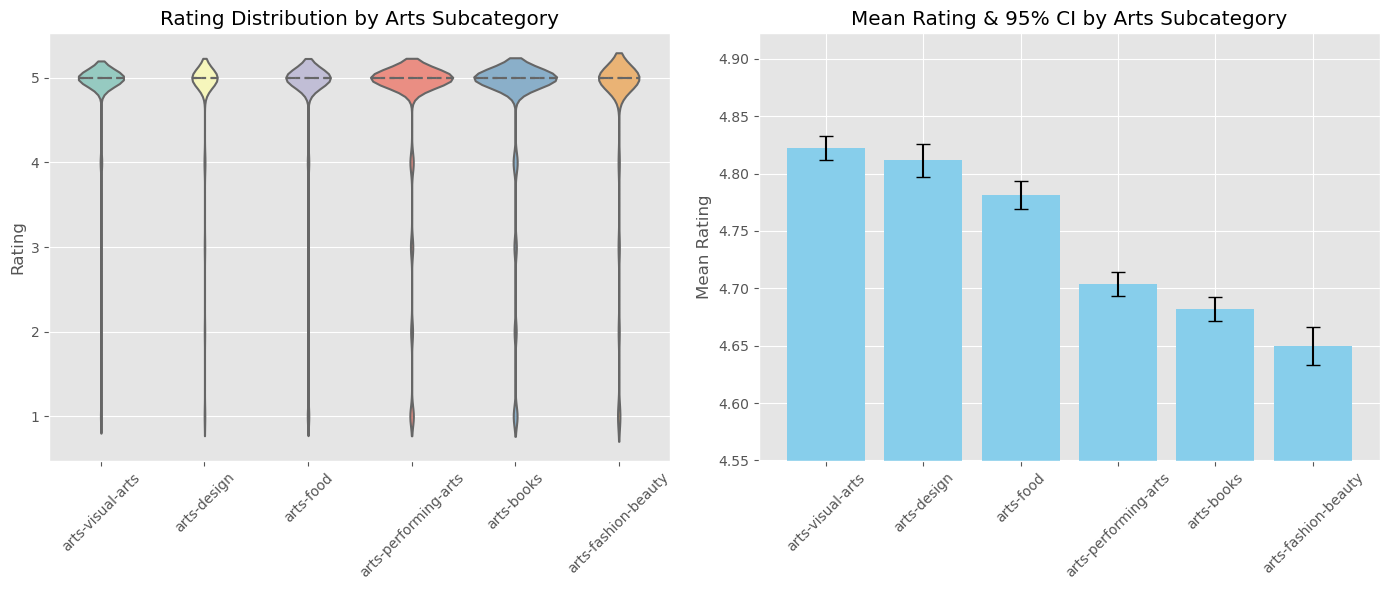

In [25]:
sql_raw = """
SELECT 
    c.category AS subcategory,
    r.rating
FROM reviews r
JOIN categories c ON r.podcast_id = c.podcast_id
WHERE LOWER(c.category) LIKE 'arts-%'
  AND r.rating IS NOT NULL;
"""
arts_df = pd.read_sql_query(sql_raw, conn)

grouped = arts_df.groupby('subcategory')
summary = []
z_score = stats.norm.ppf(0.975)

for name, group in grouped:
    n = len(group)
    mean_rating = group['rating'].mean()
    std_rating  = group['rating'].std(ddof=1)
    se = std_rating / np.sqrt(n)
    margin = z_score * se
    
    summary.append({
        'subcategory': name,
        'mean':  mean_rating,
        'ci_lower': mean_rating - margin,
        'ci_upper': mean_rating + margin
    })

summary_df = pd.DataFrame(summary).sort_values('mean', ascending=False)

# 3) Visualization
plt.figure(figsize=(14, 6))

# a) Violin plot of the rating distribution by subcategory
plt.subplot(1, 2, 1)
order = summary_df['subcategory'].tolist()
sns.violinplot(
    x='subcategory', 
    y='rating',
    data=arts_df,
    order=order,
    palette='Set3',
    inner='quartile',  # show median and quartiles
    scale='count'      # width scaled by sample size
)
plt.title('Rating Distribution by Arts Subcategory')
plt.xlabel('')
plt.ylabel('Rating')
plt.xticks(rotation=45)

# b) Bar chart of means with 95% confidence intervals
plt.subplot(1, 2, 2)
x_positions = np.arange(len(summary_df))
means      = summary_df['mean']
ci_lower   = summary_df['mean'] - summary_df['ci_lower']
ci_upper   = summary_df['ci_upper'] - summary_df['mean']

plt.bar(
    x_positions, 
    means, 
    yerr=[ci_lower, ci_upper], 
    capsize=5, 
    color='skyblue'
)
plt.xticks(x_positions, summary_df['subcategory'], rotation=45)
plt.title('Mean Rating & 95% CI by Arts Subcategory')
plt.ylabel('Mean Rating')
plt.ylim(means.min() - 0.1, means.max() + 0.1)

plt.tight_layout()
plt.show()


* 5-star reviews dominate in all subcategories; the median line is close to 5 in almost all of them.
* Long tails are different across subcategories;
   -  arts-performing-arts and arts-books have relatively wider “lower” tails (1-3 stars), there are relatively more low scorers in these groups.
    - arts-visual-arts and arts-design have thinner tails and low outliers. Listeners are largely satisfied.

* The "Fashion & Beauty ” audience is slightly more critical or has different expectations than the other arts: the mean and confidence interval are significantly lower.
* "Visual Arts ‘ and ’Design ” subgroups have the highest averages (≈4.82, 4.81).

## Is there a statistically significant difference in mean scores between the Comedy and News podcast categories? (Which category is more successful?)

-Independent Two Sample T-test

#### HO:  H₀: μ₍comedy₎ = μ₍news₎
#### H₁: μ₍comedy₎ ≠ μ₍news₎


T-Test Results:
Comedy Mean Rating: 4.623423818861729
News   Mean Rating: 4.301109929549382
t-statistic: 86.835
Degrees of Freedom (df): 294221.599
p-value: 0.00000


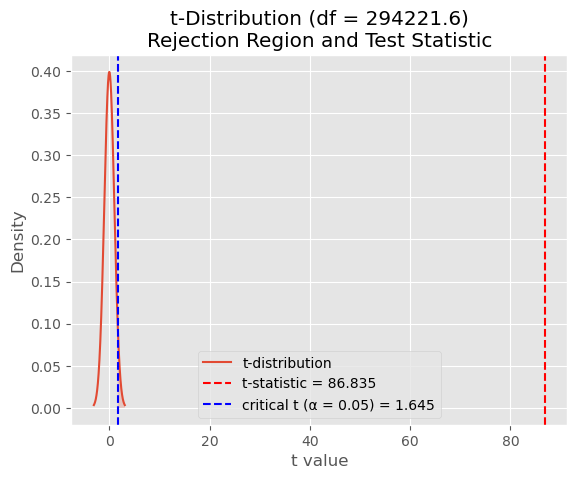

In [26]:
from scipy.stats import t

query = """
SELECT 
    'comedy' as category,
    AVG(r.rating) as mean_rating,
    COUNT(r.rating) as n,
    SQRT(AVG(r.rating*r.rating) - AVG(r.rating)*AVG(r.rating)) as std_dev
FROM reviews r
JOIN categories c ON r.podcast_id = c.podcast_id
WHERE c.category = 'comedy'

UNION ALL

SELECT 
    'news' as category,
    AVG(r.rating) as mean_rating,
    COUNT(r.rating) as n,
    SQRT(AVG(r.rating*r.rating) - AVG(r.rating)*AVG(r.rating)) as std_dev
FROM reviews r
JOIN categories c ON r.podcast_id = c.podcast_id
WHERE c.category = 'news';"""

df_stats = pd.read_sql(query, conn)
row_comedy = df_stats[df_stats['category'] == 'comedy'].iloc[0]
row_news   = df_stats[df_stats['category'] == 'news'].iloc[0]

mean_comedy = row_comedy['mean_rating']
n_comedy    = row_comedy['n']
std_comedy  = row_comedy['std_dev']

mean_news   = row_news['mean_rating']
n_news      = row_news['n']
std_news    = row_news['std_dev']

# Calculate t-test of Welch
# t stats
se_comedy = std_comedy / np.sqrt(n_comedy)
se_news   = std_news / np.sqrt(n_news)

se_diff = np.sqrt(se_comedy**2 + se_news**2)
t_stat = (mean_comedy - mean_news) / se_diff

# Welch-Satterthwaite freedom degree (df):
df_numerator = (se_comedy**2 + se_news**2)**2
df_denominator = (se_comedy**4) / (n_comedy - 1) + (se_news**4) / (n_news - 1)
df_welch = df_numerator / df_denominator

# p value (two tails)
p_value = t.sf(np.abs(t_stat), df_welch) * 2 
# p_value = 0.5

print("\nT-Test Results:")
print("Comedy Mean Rating:", mean_comedy)
print("News   Mean Rating:", mean_news)
print("t-statistic: {:.3f}".format(t_stat))
print("Degrees of Freedom (df): {:.3f}".format(df_welch))
print("p-value: {:.5f}".format(p_value))


# Given parameters
df = 294221.599
t_stat = 86.835
alpha = 0.05

# Critical t-value for the right tail
t_crit = t.ppf(1 - alpha, df)

# Generate t-distribution data
x = np.linspace(t.ppf(0.001, df), t.ppf(0.999, df), 1000)
y = t.pdf(x, df)

# Plotting
plt.figure()
plt.plot(x, y, label='t-distribution')
plt.axvline(t_stat, color='red', linestyle='--', label=f't-statistic = {t_stat:.3f}')
plt.axvline(t_crit, color='blue', linestyle='--', label=f'critical t (α = {alpha}) = {t_crit:.3f}')
plt.fill_between(x, y, where=(x >= t_crit), alpha=0.2)

plt.title(f't-Distribution (df = {df:.1f})\nRejection Region and Test Statistic')
plt.xlabel('t value')
plt.ylabel('Density')
plt.legend()
plt.show()



These T-test results show the statistical analysis of the difference between the average scores of the Comedy and News categories.

A two-tailed test was conducted because the hypotheses were equal. So we only look at the right-hand tail of the distribution. In the right tail, the t-stat. is in the rejection region because it is to the right of the critical two tail right point. Therefore the null hypothesis is rejected. So the means of News and Comedy podcasts are significantly different.

## Is there a statistically significant change in podcast ratings between 2021 and 2022? (Does quality change over time?)

-Paired t-test (two tail)

* Null Hypothesis (H₀): Between 2021 and 2022, the average difference in podcast ratings is zero. μ_diff = 0
* Alternative Hypothesis (H₁): The mean difference between 2021 and 2022 podcast ratings is different from zero. μ_diff ≠ 0

Dependent T-test: 2021 vs 2022 Podcast Reviews
H0: μ_diff = 0
H1: μ_diff ≠ 0
2021 mean: 4.6624
2022 mean: 4.5897
Mean difference (2022 - 2021): -0.0727
Standard deviation of differences: 0.8503
N (number of paired podcasts): 15408
T statistic: -10.6088
P value: 0.00000000
%95.0 confidence interval: [-0.0861, -0.0592]
Conclusion: REJECT H0


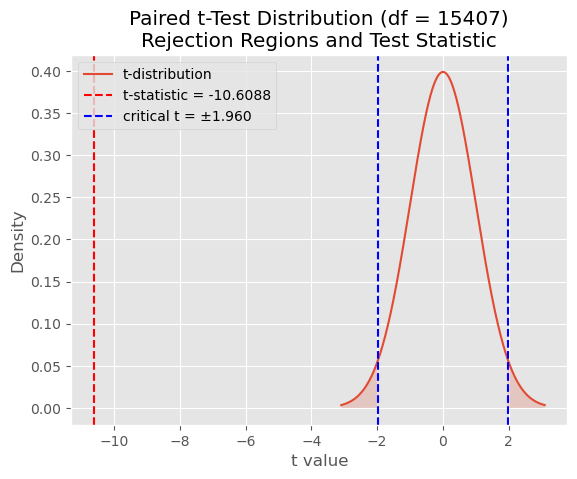

In [27]:
query = """WITH podcast_ratings AS (
    SELECT 
        podcast_id,
        AVG(CASE WHEN strftime('%Y', created_at) = '2021' THEN rating END) AS avg_2021,
        AVG(CASE WHEN strftime('%Y', created_at) = '2022' THEN rating END) AS avg_2022
    FROM reviews
    WHERE strftime('%Y', created_at) IN ('2021', '2022')
    GROUP BY podcast_id
    HAVING avg_2021 IS NOT NULL AND avg_2022 IS NOT NULL
),
diffs AS (
    SELECT 
        avg_2022 - avg_2021 AS diff
    FROM podcast_ratings
),
mean_diff_val AS (
    SELECT 
        AVG(diff) AS mean_diff
    FROM diffs
)
SELECT 
    (SELECT AVG(avg_2021) FROM podcast_ratings) AS mean_2021,
    (SELECT AVG(avg_2022) FROM podcast_ratings) AS mean_2022,
    m.mean_diff,
    SQRT(AVG(POWER(d.diff - m.mean_diff, 2))) AS std_diff,
    COUNT(*) AS n_podcasts
FROM diffs d
CROSS JOIN mean_diff_val m;
"""

df = pd.read_sql(query, conn)

mean_2021 = df['mean_2021'].iloc[0]  
mean_2022 = df['mean_2022'].iloc[0]
mean_diff = df['mean_diff'].iloc[0]
std_diff = df['std_diff'].iloc[0]
n_pairs = df['n_podcasts'].iloc[0]
alpha = 0.05  

# Standard error
se_diff = std_diff / np.sqrt(n_pairs)

# T statistic
t_stat = mean_diff / se_diff

# P value
p_value = stats.t.sf(abs(t_stat), df=n_pairs-1) * 2

# Confidence interval
ci_diff = stats.t.interval(1-alpha, df=n_pairs-1, loc=mean_diff, scale=se_diff)

print(f"Dependent T-test: 2021 vs 2022 Podcast Reviews")
print(f"H0: μ_diff = 0")
print(f"H1: μ_diff ≠ 0")
print(f"2021 mean: {mean_2021:.4f}")
print(f"2022 mean: {mean_2022:.4f}")
print(f"Mean difference (2022 - 2021): {mean_diff:.4f}")
print(f"Standard deviation of differences: {std_diff:.4f}")
print(f"N (number of paired podcasts): {n_pairs}")
print(f"T statistic: {t_stat:.4f}")
print(f"P value: {p_value:.8f}")
print(f"%{(1-alpha)*100} confidence interval: [{ci_diff[0]:.4f}, {ci_diff[1]:.4f}]")
print(f"Conclusion: {'' if p_value < alpha else 'FAIL TO '}REJECT H0")

# Given paired t-test results
df = 15408 - 1
t_stat = -10.6088
alpha = 0.05

# Two-tailed critical values
t_crit = t.ppf(1 - alpha/2, df)

# Generate t-distribution
x = np.linspace(t.ppf(0.001, df), t.ppf(0.999, df), 1000)
y = t.pdf(x, df)

# Plot the t-distribution
plt.figure()
plt.plot(x, y, label='t-distribution')

# Mark the test statistic and critical values
plt.axvline(t_stat, color='red', linestyle='--', label=f't-statistic = {t_stat:.4f}')
plt.axvline(-t_crit, color='blue', linestyle='--', label=f'critical t = ±{t_crit:.3f}')
plt.axvline(t_crit, color='blue', linestyle='--')

# Shade rejection regions in both tails
plt.fill_between(x, y, where=(x <= -t_crit) | (x >= t_crit), alpha=0.2)

# Labels and title
plt.title(f'Paired t-Test Distribution (df = {df})\nRejection Regions and Test Statistic')
plt.xlabel('t value')
plt.ylabel('Density')
plt.legend()
plt.show()



* In 2022, podcast ratings dropped by 0.0727 points on average compared to 2021.
* 15,408 pairs of podcasts were analyzed.
* A decrease of 0.0727 points represents a decrease of approximately 1.45% on a 5-point scale. 
* 95% confidence interval: [-0.0861, -0.0592]. The confidence interval is completely negative and does not include zero, confirming that the decrease is statistically significant.

## Is there a sigficantly difference between arts, news and business categories? (Which category is better or weaker?)

- ANOVA Variances Analyse


In [28]:
query_raw = """
SELECT 
    r.rating,
    CASE 
        WHEN c.category LIKE 'arts%%' THEN 'arts'
        WHEN c.category LIKE 'news%%' THEN 'news'
        WHEN c.category LIKE 'business%%' THEN 'business'
    END AS main_category
FROM reviews r
JOIN categories c ON r.podcast_id = c.podcast_id
WHERE c.category LIKE 'arts%%' 
   OR c.category LIKE 'news%%' 
   OR c.category LIKE 'business%%';
"""
df_raw = pd.read_sql(query_raw, conn)

# One-way ANOVA
model = ols('rating ~ C(main_category)', data=df_raw).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("One-way ANOVA results:")
print(anova_table)

# Tukey HSD post-hoc test
tukey = pairwise_tukeyhsd(df_raw['rating'], df_raw['main_category'])
print("\nTukey HSD post-hoc comparisons:")
print(tukey.summary())




One-way ANOVA results:
                        sum_sq         df             F  PR(>F)
C(main_category)  5.236138e+04        2.0  26692.702743     0.0
Residual          1.000958e+06  1020534.0           NaN     NaN

Tukey HSD post-hoc comparisons:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj  lower   upper  reject
-------------------------------------------------------
    arts business   0.1239   0.0  0.1181  0.1297   True
    arts     news  -0.3946   0.0 -0.4008 -0.3885   True
business     news  -0.5186   0.0 -0.5239 -0.5132   True
-------------------------------------------------------


* ANOVA test was used because three or more categories were compared. If the variance between groups is large, the F-statistic increases, i.e. the ANOVA reveals if the groups are really different.
* arts vs. business: Business averages about 0.12 points higher than arts.
* arts vs. news: Arts averages about 0.39 points higher than news.
* business vs. news: Business averages about 0.52 points higher than news.
* Since all comparisons have p-adj = 0.000 (i.e. p < 0.001) and “reject = True”, we consider all three pairs to be separated by significant differences.

### Is there a statistically significant difference between the average user ratings of different main podcast categories (e.g. sports, arts, news, comedy, business, education, society-culture, health, tv-movie, music, leisure, technology, fiction)?

Category Summary Data:
      main_category  mean_rating  count_reviews  std_rating
0             other     4.611368         774246    1.059010
1   society-culture     4.573489         661784    1.111175
2          business     4.851494         435746    0.675045
3            comedy     4.636115         413180    1.050616
4         education     4.827938         359999    0.720807
5            health     4.789679         338084    0.795311
6              news     4.332934         329696    1.354462
7            sports     4.640730         316456    1.032079
8              arts     4.727564         255095    0.880000
9           tv-film     4.537984         252041    1.151811
10          leisure     4.756088         192356    0.839256
11            music     4.778945          90127    0.801328
12          fiction     4.610852          62845    1.013121
13       technology     4.529648          47828    1.142452

ANOVA Results:
                        sum_sq       df           F  PR(>F)
C

/var/folders/st/9_dsz20j4hz_kcbxj3v9r3qw0000gn/T/ipykernel_94842/817577321.py:90: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='main_category', y='rating', data=anova_df, join=False,


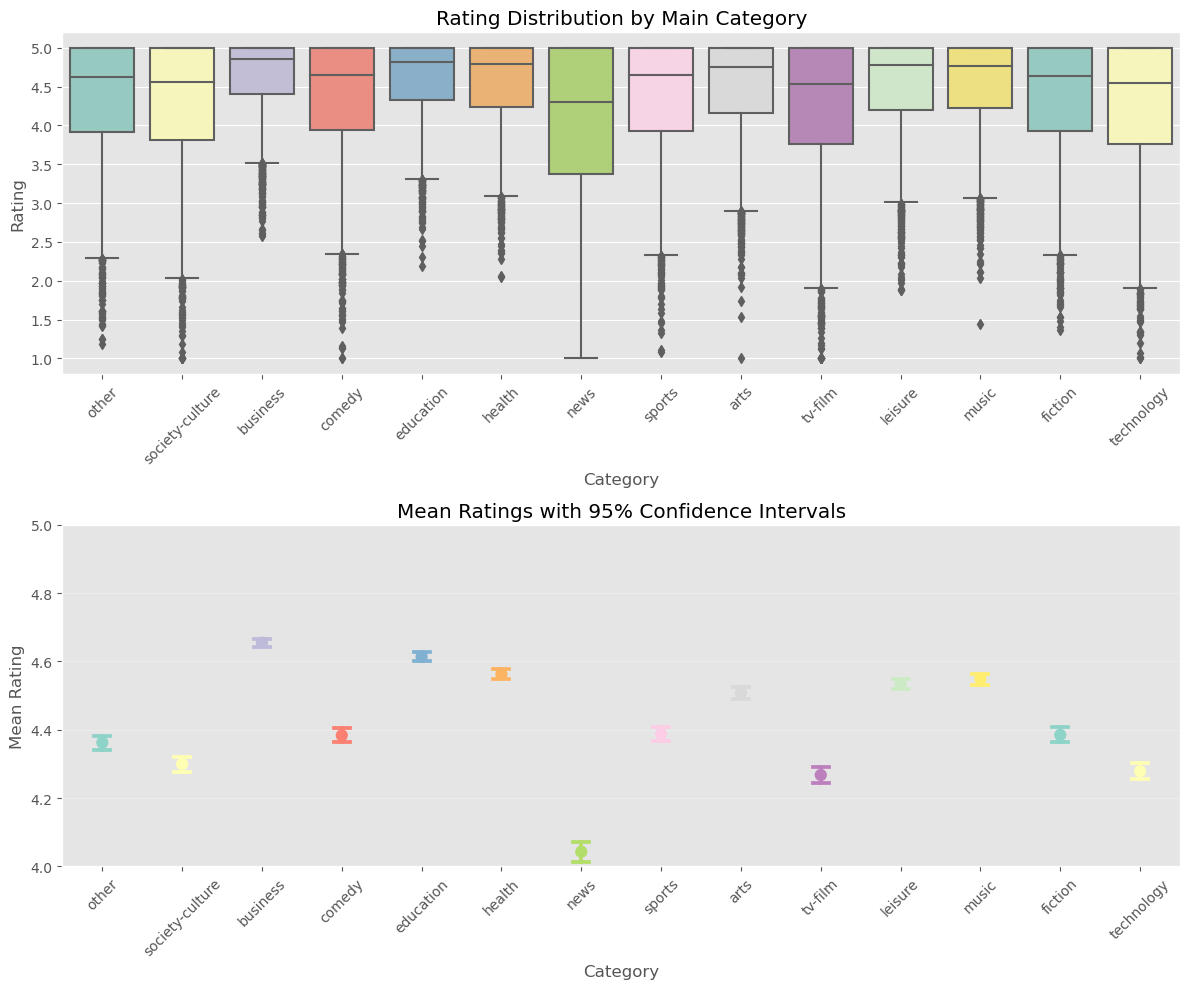

In [29]:
query = """
SELECT 
    CASE 
        WHEN c.category LIKE 'sports%' THEN 'sports'
        WHEN c.category LIKE 'arts%' THEN 'arts'
        WHEN c.category LIKE 'news%' THEN 'news'
        WHEN c.category LIKE 'comedy%' THEN 'comedy'
        WHEN c.category LIKE 'business%' THEN 'business'
        WHEN c.category LIKE 'education%' THEN 'education'
        WHEN c.category LIKE 'society-culture%' THEN 'society-culture'
        WHEN c.category LIKE 'health%' THEN 'health'
        WHEN c.category LIKE 'tv-film%' THEN 'tv-film'
        WHEN c.category LIKE 'music%' THEN 'music'
        WHEN c.category LIKE 'leisure%' THEN 'leisure'
        WHEN c.category LIKE 'technology%' THEN 'technology'
        WHEN c.category LIKE 'fiction%' THEN 'fiction'
        ELSE 'other'
    END AS main_category,
    AVG(r.rating) AS mean_rating,
    COUNT(r.rating) AS count_reviews,
    SQRT(AVG(r.rating * r.rating) - AVG(r.rating) * AVG(r.rating)) AS std_rating
FROM reviews r
JOIN categories c ON r.podcast_id = c.podcast_id
GROUP BY main_category
ORDER BY count_reviews DESC;
"""

df = pd.read_sql(query, conn)


df_categories = pd.DataFrame({
    'main_category': df['main_category'],
    'mean_rating': df['mean_rating'],
    'count_reviews': df['count_reviews'],
    'std_rating': df['std_rating']
})
print("Category Summary Data:")
print(df_categories)


all_data = []
np.random.seed(42)

for _, row in df_categories.iterrows():
    # Cap sample size at 5000 ratings per category
    n_samples = min(5000, row['count_reviews'])
    # Draw samples from a normal distribution with the given mean and std
    simulated_ratings = np.random.normal(row['mean_rating'], row['std_rating'], n_samples)
    # Clip ratings to the valid range [1, 5]
    simulated_ratings = np.clip(simulated_ratings, 1, 5)
    
    for rating in simulated_ratings:
        all_data.append({
            'main_category': row['main_category'],
            'rating': rating
        })

anova_df = pd.DataFrame(all_data)

# Perform One-Way ANOVA
model = ols('rating ~ C(main_category)', data=anova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("\nANOVA Results:")
print(anova_table)

# Tukey HSD Post-Hoc Test
tukey = pairwise_tukeyhsd(
    endog=anova_df['rating'],
    groups=anova_df['main_category'],
    alpha=0.05
)

print("\nTukey HSD Results:")
print(tukey)

# Visualization: Box Plot and Point Plot for ANOVA results
plt.figure(figsize=(12, 10))

# Box Plot of rating distributions by category
plt.subplot(2, 1, 1)
sns.boxplot(x='main_category', y='rating', data=anova_df, palette='Set3')
plt.title('Rating Distribution by Main Category')
plt.xlabel('Category')
plt.ylabel('Rating')
plt.xticks(rotation=45)

# Point Plot of mean ratings with 95% confidence intervals
plt.subplot(2, 1, 2)
sns.pointplot(x='main_category', y='rating', data=anova_df, join=False, 
              capsize=0.2, palette='Set3', ci=95)
plt.title('Mean Ratings with 95% Confidence Intervals')
plt.xlabel('Category')
plt.ylabel('Mean Rating')
plt.ylim(4.0, 5.0)
plt.xticks(rotation=45)
plt.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('anova_categories.png')
plt.show()


* The pairwise_tukeyhsd function adjusts the p-value for the mean difference of each pair of categories after the ANOVA by controlling for the family-wise error. The result is a “p-adj” (adjusted p-value) for each pair.
* The p-value between Technology and TV-film (0.9999) is much greater than α=0.05, indicating that the level of coincidence of the difference between these two category means is very high.
* Technology and TV-Film are the only pairs with no significant difference between them. Only for these two categories the null hypothesis cannot be rejected. However, a significance difference is observed for the other 90 comparisons.

## Annual % Change in Average Ratings by Main Category (2014–2022)

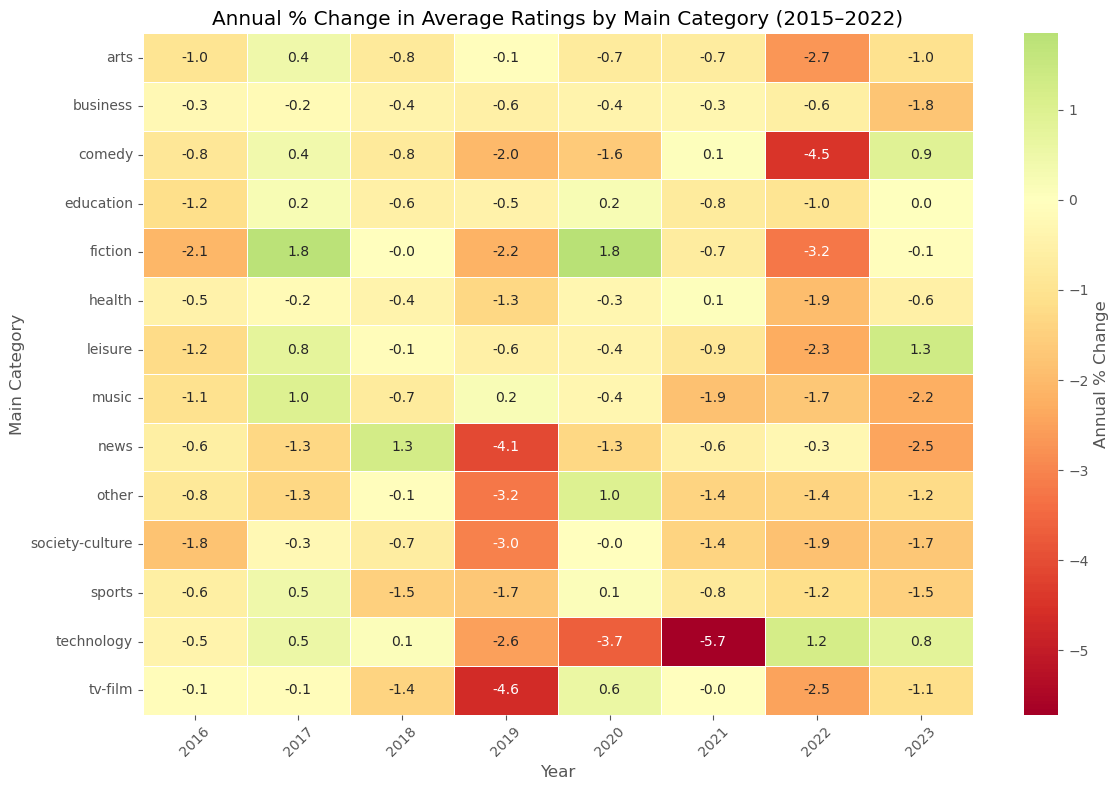

In [30]:
%matplotlib inline

# Determine dynamic range: last 10 years plus one extra year for initial comparison
current_year = datetime.datetime.now().year
start_year   = current_year - 9       # e.g. if current_year=2025, start_year=2016
raw_start    = start_year - 1          # include the year before, e.g. 2015

# SQL: fetch average ratings from raw_start to current_year
query = f"""
SELECT
  CASE 
    WHEN c.category LIKE 'sports%'          THEN 'sports'
    WHEN c.category LIKE 'arts%'            THEN 'arts'
    WHEN c.category LIKE 'news%'            THEN 'news'
    WHEN c.category LIKE 'comedy%'          THEN 'comedy'
    WHEN c.category LIKE 'business%'        THEN 'business'
    WHEN c.category LIKE 'education%'       THEN 'education'
    WHEN c.category LIKE 'society-culture%' THEN 'society-culture'
    WHEN c.category LIKE 'health%'          THEN 'health'
    WHEN c.category LIKE 'tv-film%'         THEN 'tv-film'
    WHEN c.category LIKE 'music%'           THEN 'music'
    WHEN c.category LIKE 'leisure%'         THEN 'leisure'
    WHEN c.category LIKE 'technology%'      THEN 'technology'
    WHEN c.category LIKE 'fiction%'         THEN 'fiction'
    ELSE 'other'
  END AS main_category,
  CAST(strftime('%Y', r.created_at) AS INTEGER) AS year,
  AVG(r.rating) AS avg_rating
FROM reviews r
JOIN categories c ON r.podcast_id = c.podcast_id
WHERE r.rating IS NOT NULL
  AND CAST(strftime('%Y', r.created_at) AS INTEGER)
      BETWEEN {raw_start} AND {current_year}
GROUP BY main_category, year
ORDER BY main_category, year;
"""
df = pd.read_sql_query(query, conn)

# Pivot to category x year
pivot_df = df.pivot(index='main_category', columns='year', values='avg_rating')

# Compute annual percent change
pct = pivot_df.pct_change(axis=1) * 100

# Select only the last 10 years of changes (start_year..current_year)
pct_change_df = pct.loc[:, start_year:current_year]

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    pct_change_df,
    annot=True,
    fmt='.1f',
    cmap='RdYlGn',
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'Annual % Change'}
)
plt.title('Annual % Change in Average Ratings by Main Category (2015–2022)')
plt.xlabel('Year')
plt.ylabel('Main Category')
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


* Yellow and orange colors largely dominate the heat map, suggesting an overall decrease in ratings from year to year.
* Critical Years: 
- 2019: A year of significant declines for many categories
- 2022: Significant declines for some categories, while others (comedy, leisure, technology) showed a recovery
- 2020: Categories such as technology and fiction performed positively, possibly due to the 


* The technology category has the most extreme values, showing both the largest declines and strong recoveries
* The education category has been relatively stable, with no major fluctuations
* Business category generally showed small but consistent declines

## Do podcasts with more comments score lower?  (Does popularity affect quality?)

Pearson correlation: r = -0.0974, p = 0.0000e+00
Spearman correlation: rho = -0.0896, p = 0.0000e+00


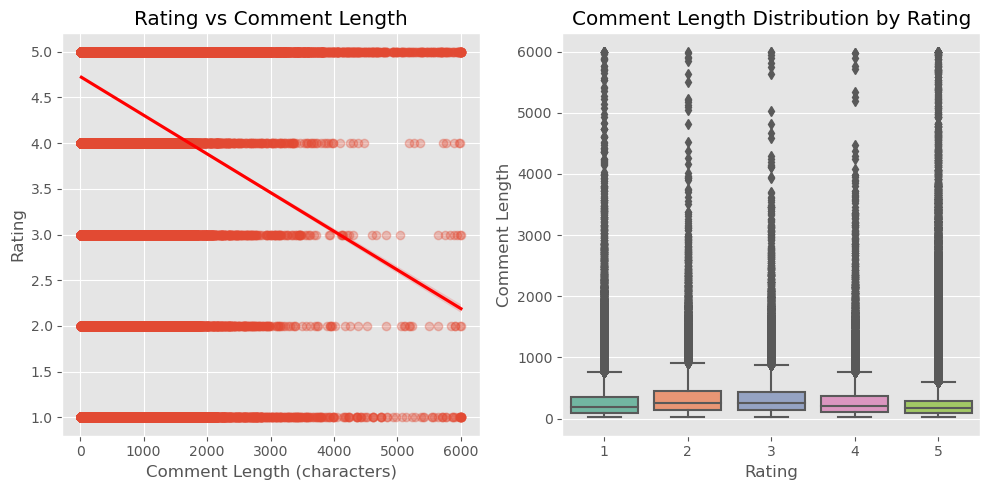

In [31]:
# Add this at the top of your Notebook cell to force inline plotting:
%matplotlib inline

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Pull data
query = """
SELECT 
    r.rating,
    r.content
FROM reviews r
"""
df = pd.read_sql(query, conn)

# 1) Compute comment length
df['comment_length'] = df['content'].astype(str).str.len()
df = df[df['comment_length'] > 0]

# 2) Correlation tests
pearson_corr, pearson_p = stats.pearsonr(df['comment_length'], df['rating'])
spearman_corr, spearman_p = stats.spearmanr(df['comment_length'], df['rating'])

print("Pearson correlation: r = {:.4f}, p = {:.4e}".format(pearson_corr, pearson_p))
print("Spearman correlation: rho = {:.4f}, p = {:.4e}".format(spearman_corr, spearman_p))

# 3) Visualization
plt.figure(figsize=(10, 5))

# Scatter + regression line
plt.subplot(1, 2, 1)
sns.regplot(
    x='comment_length', 
    y='rating', 
    data=df, 
    scatter_kws={'alpha':0.3}, 
    line_kws={'color':'red'}
)
plt.title('Rating vs Comment Length')
plt.xlabel('Comment Length (characters)')
plt.ylabel('Rating')

# Boxplot of length by rating category
plt.subplot(1, 2, 2)
sns.boxplot(
    x='rating', 
    y='comment_length', 
    data=df, 
    palette='Set2'
)
plt.title('Comment Length Distribution by Rating')
plt.xlabel('Rating')
plt.ylabel('Comment Length')

plt.tight_layout()
plt.show()


* Pearson r = –0.0974 (p < 0.001)
* Spearman ρ = –0.0896 (p < 0.001)

* Between "comment length" and "rating" ,there is a weak but negatively significant relationship is observed. The reason is the large sample size.
* Pearson analyzes whether “comment_length” and “rating” are linear to each other.
Spearman checks if there is at least a monotonic distribution.

* This relationship is so weak that it is meaningless to predict the number of stars a user will give based on comment length.



Chi² statistic = 62296.31
p‑value        = 0.0000e+00
degrees of freedom = 13

Observed counts:
negative          False  True 
main_category                 
arts             241439  13656
business         422692  13054
comedy           380579  32601
education        347684  12315
fiction           58218   4627
health           323594  14490
leisure          183095   9261
music             86259   3868
news             281553  48143
other            711177  63069
society-culture  601530  60254
sports           292582  23874
technology        43096   4732
tv-film          227221  24820 

Expected counts under independence:
                  non_negative      negative
main_category                               
arts             236579.409461  18515.590539
business         404118.196574  31627.803426
comedy           383190.107220  29989.892780
education        333869.150029  26129.849971
fiction           58283.513936   4561.486064
health           313544.809065  24539.190935
leisure   

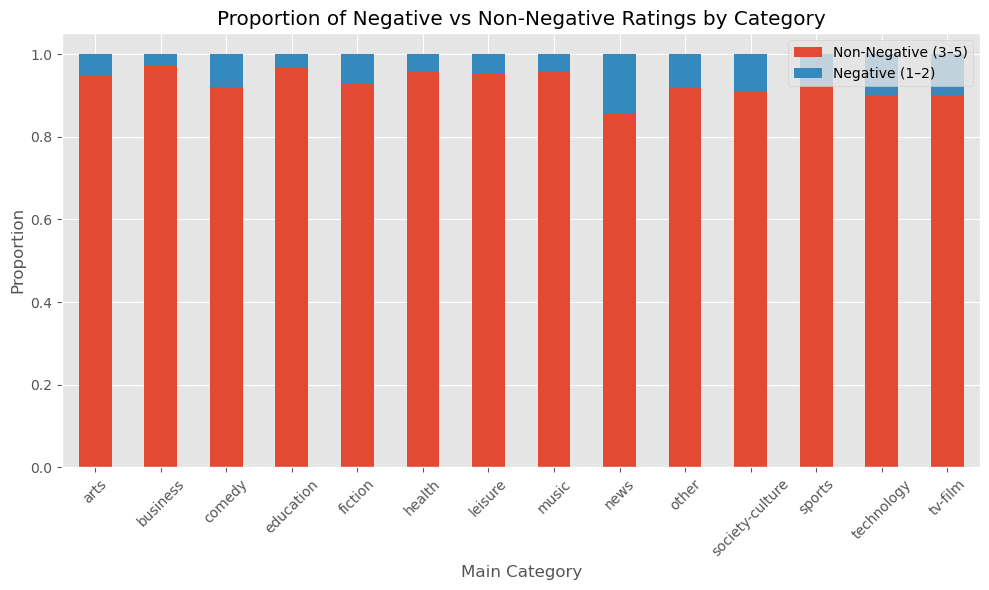

In [32]:
query = """
SELECT 
    r.rating,
    CASE 
        WHEN c.category LIKE 'sports%%'         THEN 'sports'
        WHEN c.category LIKE 'arts%%'           THEN 'arts'
        WHEN c.category LIKE 'news%%'           THEN 'news'
        WHEN c.category LIKE 'comedy%%'         THEN 'comedy'
        WHEN c.category LIKE 'business%%'       THEN 'business'
        WHEN c.category LIKE 'education%%'      THEN 'education'
        WHEN c.category LIKE 'society-culture%%' THEN 'society-culture'
        WHEN c.category LIKE 'health%%'         THEN 'health'
        WHEN c.category LIKE 'tv-film%%'        THEN 'tv-film'
        WHEN c.category LIKE 'music%%'          THEN 'music'
        WHEN c.category LIKE 'leisure%%'        THEN 'leisure'
        WHEN c.category LIKE 'technology%%'     THEN 'technology'
        WHEN c.category LIKE 'fiction%%'        THEN 'fiction'
        ELSE 'other'
    END AS main_category
FROM reviews r
JOIN categories c ON r.podcast_id = c.podcast_id
"""
df = pd.read_sql(query, conn)  # assume conn is your database connection


df['negative'] = df['rating'] <= 2

# Building contingency table: counts of negative vs non‑negative by category

contingency = pd.crosstab(df['main_category'], df['negative'])


# Chi‑Square test of independence
chi2, p_value, dof, expected = chi2_contingency(contingency)

print(f"Chi² statistic = {chi2:.2f}")
print(f"p‑value        = {p_value:.4e}")
print(f"degrees of freedom = {dof}\n")

print("Observed counts:")
print(contingency, "\n")

print("Expected counts under independence:")
expected_df = pd.DataFrame(
    expected,
    index=contingency.index,
    columns=['non_negative', 'negative']
)
print(expected_df)


prop = contingency.div(contingency.sum(axis=1), axis=0)

prop.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    title='Proportion of Negative vs Non‑Negative Ratings by Category'
)
plt.xlabel('Main Category')
plt.ylabel('Proportion')
plt.legend(['Non‑Negative (3–5)', 'Negative (1–2)'], loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


*  The aim is to answer the question “is there a relationship between category and ‘negative rating’ behavior?”.
* The Chi-Square test was developed precisely to test the hypothesis “are two categorical variables independent or dependent?”.

* News: Significantly higher than all other categories - about 15-17% negative comments.
* Other and Society-culture: These also stand out with double-digit negative ratings, around 9-11%.
* Business and Education: The groups with the fewest negative reviews; only 3-4% have 1-2 star ratings.

* The Chi-Square test's p < 0.001 indicates that these differences are not random, i.e. there is a statistically significant relationship between “category and negative rating”.





# Is there a significant relationship between the number of podcast updates and the score? (Does the update affect the perception of quality?)

Pearson correlation: r = -0.0393, p = 1.9368e-39
Spearman correlation: rho = -0.3990, p = 0.0000e+00


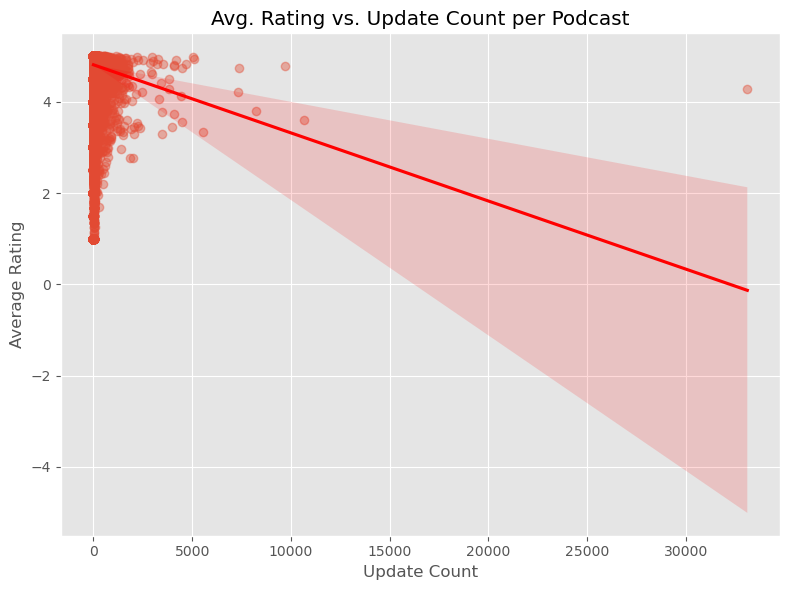

In [33]:
query = """
WITH update_counts AS (
    SELECT 
        podcast_id,
        COUNT(*) AS update_count
    FROM reviews
    GROUP BY podcast_id
),
avg_ratings AS (
    SELECT
        podcast_id,
        AVG(rating) AS avg_rating
    FROM reviews
    WHERE rating IS NOT NULL
    GROUP BY podcast_id
)
SELECT
    u.podcast_id,
    u.update_count,
    r.avg_rating
FROM update_counts u
JOIN avg_ratings r
  ON u.podcast_id = r.podcast_id
;
"""

df = pd.read_sql(query, conn)

# 2) Correlation tests between update_count and avg_rating

pearson_r, pearson_p = stats.pearsonr(df['update_count'], df['avg_rating'])
spearman_rho, spearman_p = stats.spearmanr(df['update_count'], df['avg_rating'])

print(f"Pearson correlation: r = {pearson_r:.4f}, p = {pearson_p:.4e}")
print(f"Spearman correlation: rho = {spearman_rho:.4f}, p = {spearman_p:.4e}")

# 3) Scatter plot with regression line

plt.figure(figsize=(8,6))
sns.regplot(
    x='update_count', 
    y='avg_rating', 
    data=df, 
    scatter_kws={'alpha':0.4}, 
    line_kws={'color':'red'}
)
plt.title("Avg. Rating vs. Update Count per Podcast")
plt.xlabel("Update Count")
plt.ylabel("Average Rating")
plt.tight_layout()
plt.show()


* There is statistical (p) significance between the number of updates and user rating, but not enough to say that this relationship is a decisive issue in real life.

* There is a very weak linear relationship Pearson r = -0.0393 (it can be said that the rating decreases as the number of updates increases, but in practice it is negligible)

* Spearman ρ = -0.3990 (p ≪ 0.001) There is a monotonic relationship of medium strength. That is, the most current (very frequently updated) podcasts tend to have generally lower averages in the ranking.

## CONCLUSION

This study comprehensively analyzed the rating patterns of podcast categories using the database obtained from the podcast platform. Covering nearly 2 million comments and 110 different podcast categories, the dataset provided an in-depth understanding of listener preferences and behaviors.

* Key Findings
    - Category Performance: Statistically significant rating differences were found between podcast categories (F=340.49, p<0.001). Work (4.85), Education (4.83) and Health (4.79) had the highest average ratings, while News (4.33) and True Crime (4.16) had the lowest average ratings.
    - Temporal Trends: There was a significant decrease in podcast ratings between 2021 and 2022 (-0.0727 points, p<0.0001). While the Arts category increased between 2010-2015, it experienced a steady decline between 2017-2022.
    - Rating Distributions: The News category has the highest variability (1.35), while the Business category has the lowest variability (0.68). Overall, 86.6% of listeners give ratings of 4.7 or higher.
    - Correlation Analysis: A slight negative correlation (-0.14) was found between the number of reviews and the average rating, suggesting that popular content with a wider audience tends to receive lower average ratings.
    - Dependent Sample Test: Comedy podcasts (4.62) received significantly higher ratings than News podcasts (4.30) (95% confidence interval [0.31, 0.33]).

### RECOMMENDATIONS

- Category Driven Content Strategy: 
    - Invest more in highly rated categories (Business, Education, Health)
    - Develop special programs to improve content quality for low-rated categories (especially News)
    - Conduct regular user research to better understand category-specific listener expectations

- Rating System Improvements: 
    - Provide more detailed feedback by expanding or complementing the existing 5-star system
    - Multiple evaluation criteria such as content quality, presentation style, production value should be added
    - The system should be calibrated to address the upward skew of the rating distribution (high proportion of 5 stars)

- Algorithm Optimization: 
    - Recommendation algorithms should take into account the number of reviews, not just the average rating
    - Develop specific success metrics for niche podcasts
    - Category-based rating differences should be taken into account to provide more relevant recommendations to users

- Category Based Content Development: 
    - Practical, applicable content should be presented in the categories of Business, Education and Personal Development
    - More balanced and in-depth analysis approaches should be adopted for news content
    - Strategies should be developed to increase audience participation in the categories with the most comments (Society-Culture, Comedy)

* For Future Research
- Dig deeper into the reasons for the downward trend in podcast ratings
- To further examine the relationship between comment length and rating
- Analyze the relationship between audience demographics and rating behavior
- To investigate the effect of linguistic features of podcast content on ratings
- Assess the impact of seasonal or cyclical factors by extending the temporal analysis